In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D  
import statsmodels.api as sm
from time import time
import os
from scipy import signal
import datetime

In [2]:
import CCCV_cycle_breakdown as CCCV_cap 
import select_cycle_plotter as selector

In [ ]:
# uncomment below for install of rfbzero
#! pip install rfbzero

In [4]:
from rfbzero.redox_flow_cell import ZeroDModel
from rfbzero.degradation import (ChemicalDegradationOxidized,
                                 ChemicalDegradationReduced,
                                 MultiDegradationMechanism,
                                 Dimerization)
from rfbzero.crossover import Crossover
from rfbzero.experiment import ConstantCurrentConstantVoltage

In [37]:
# plotting parameters
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],   
})
plt.rc('axes', linewidth=1.2, labelsize=10)   # fontsize of the x and y labels (words)
plt.rc('xtick', labelsize=9)                  # fontsize of the tick labels (numbers) #labelsize=MEDIUM
plt.rc('ytick', labelsize=9)                  # fontsize of the tick labels
plt.rc('legend', fontsize=8)                  # legend fontsize

x_ticks = { "top" : True, "direction" : "in", "minor.visible" : True,
            "major.size" : 4, "major.width" :  1.2, "minor.size" : 2, "minor.width" : 0.5}

y_ticks = x_ticks.copy()
y_ticks["right"] = y_ticks.pop("top")
plt.rc('xtick', **x_ticks)
plt.rc('ytick', **y_ticks)

# fig size
single_width = 3.25 # inches
double_width = 7.0 #inches

cycle_data_path = "./raw_data/"

## useful functions

In [11]:
def get_cycle_data(df):
    charge_time = df['Time (h)'][0::2] / 24        # days
    discharge_time = df['Time (h)'][1::2] / 24     # days
    discharge = df['Discharge (Ah)'][1::2] * 3600  # coulombs
    charge = df['Charge (Ah)'][0::2] * 3600        # coulombs
    return charge_time.to_numpy(), discharge_time.to_numpy(), discharge.to_numpy(), charge.to_numpy()
###############################################
def find_nearest(array, value):     
    array = np.asarray(array)   
    idx = (np.abs(array - value)).argmin()     
    return idx
##########################################
def get_CE_vals(charge_cap, discharge_cap, time):
    if len(charge_cap) > len(discharge_cap):
        CE_vals = np.divide(discharge_cap[1:], charge_cap[1:-1])*100
        CE_time = time[1:]
    elif len(charge_cap) < len(discharge_cap):
        CE_vals = np.divide(discharge_cap[1:-1], charge_cap[1:])*100
        CE_time = time[1:-1]
    else:    
        CE_vals = np.divide(discharge_cap[1:], charge_cap[1:])*100 #cuts first half charge
        CE_time = time[1:] # where would one put the time value? C? D?
    return CE_time, CE_vals
#################################################################
def data_fitting(x,y):
    # statsmodels api
    X = sm.add_constant(x)  # Adds a constant term to the predictor
    model = sm.OLS(y, X)
    results = model.fit()
    alpha = 0.05 # 95% confidence interval
    predictions = results.get_prediction(X).summary_frame(alpha)
    intercept, slope = results.params
    inter_stderr, slope_stderr = results.bse # standard error
    RSE = np.sqrt(results.mse_resid) # residual standard error
    r2 = results.rsquared # R squared
    inter_conf_int, slope_conf_int = results.conf_int(alpha, cols=None) # confidence intervals
    # calculate the margin of error for slope (either side of CI can be used), at given CI. 
    # This is the reported +/- for a fade rate
    slope_error_CI = abs(slope_conf_int[0] - slope)
    return slope, intercept, r2, slope_conf_int, inter_conf_int, predictions, slope_error_CI, RSE 
#################################################################
def time_of_cycle(charge_t, discharge_t):
    # returns cycle length in minutes
    cyc_len_d = [(discharge_t[x+1] - discharge_t[x])*1440 for x in range(len(discharge_t)-1)] 
    cyc_len_c = [(charge_t[x+1] - charge_t[x])*1440 for x in range(len(charge_t)-1)]
    return cyc_len_c, cyc_len_d
###########################################################
def fade_per_cycle(capacity_vals):
    first_capacity = capacity_vals[0]
    last_capacity = capacity_vals[-1]
    cycle_fade = (((first_capacity - last_capacity) / first_capacity)*100) / float(len(capacity_vals))
    return cycle_fade
################################################################
def section_time_CCCV(location, file, skip=0):
    time_CC_c, _, time_CV_c, _, time_CC_d, _, time_CV_d, _ = CCCV_cap.CCCV_breakdown_novonix(location, file).data_parse()
    # need to skip first 10 cycles, *60 for minute units

    # 11th CC charge - 10th CV discharge (timestamp)
    length_CC_charge = [(time_CC_c[x+1] - time_CV_d[x])*60 for x in range(skip, len(time_CC_c)-1)]#9, -1

    # 11th CV charge - 11th CC charge
    length_CV_charge = [(time_CV_c[x] - time_CC_c[x])*60 for x in range(1+skip, len(time_CV_c))]#10

    # 11th CC discharge - 11th CV charge (timestamp)
    length_CC_discharge = [(time_CC_d[x] - time_CV_c[x])*60 for x in range(1+skip, len(time_CC_d))]#10

    # 11th CV discharge - 11th CC discharge
    length_CV_discharge = [(time_CV_d[x] - time_CC_d[x])*60 for x in range(1+skip, len(time_CV_d))]#10
    
    # time in terms of fraction
    frac_CC_ch = [cc / (cc + cv) for cc,cv in zip(length_CC_charge, length_CV_charge)]
    frac_CV_ch = [1.0 - f for f in frac_CC_ch]
    
    frac_CC_dis = [cc / (cc + cv) for cc,cv in zip(length_CC_discharge, length_CV_discharge)]
    frac_CV_dis = [1.0 - f for f in frac_CC_dis]

    if len(frac_CC_ch) < len(time_CC_c[1+skip:]):
        frac_CC_ch.append(0)
    if len(frac_CV_ch) < len(time_CV_c[1+skip:]):
        frac_CV_ch.append(0)
    if len(frac_CC_dis) < len(time_CC_d[1+skip:]):
        frac_CC_dis.append(0)
    if len(frac_CV_dis) < len(time_CV_d[1+skip:]):
        frac_CV_dis.append(0)

    return (length_CC_charge, length_CV_charge, length_CC_discharge, length_CV_discharge,
           time_CC_c, time_CV_c, time_CC_d, time_CV_d, frac_CC_ch, frac_CV_ch, frac_CC_dis, frac_CV_dis)
###############################################################

# Figure 1  
### (plot discharge capacity instead of normalized capacity to obtain Figure S2)

cell NR211: fade rate: 0.080 +/- 0.003 %/day
cell NR212: fade rate: 0.069 +/- 0.001 %/day
cell N115: fade rate: 0.067 +/- 0.001 %/day
cell N117: fade rate: 0.078 +/- 0.003 %/day


Text(-0.2, 1.1, 'd.')

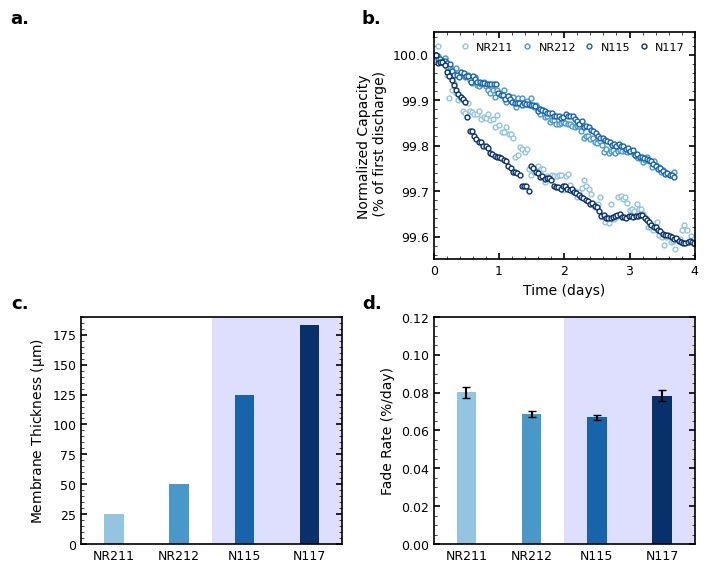

In [15]:
# Nafion 211, 212, 115, 117
thick = [25, 50, 125, 183]
all_mems = ['NR211', 'NR212', 'N115', 'N117']

exp_loc1 = cycle_data_path # 117, 211
ff1 = ["2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-04_out.csv",
       "2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-01_out.csv",
      ]

exp_loc2 = cycle_data_path
ff2 = ["2023-03-31_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-08_out.csv",
       "2023-03-31_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-05_out.csv",
      ]

all_data = [exp_loc1 + ff1[1], exp_loc2 + ff2[1], exp_loc2 + ff2[0], exp_loc1 + ff1[0]]

#############################################
fig = plt.figure(figsize=(double_width, double_width*0.8))
ax1 = plt.subplot(2, 2, 1) # blank (for cell schematic)
ax2 = plt.subplot(2, 2, 2) # norm cap vs time
ax3 = plt.subplot(2, 2, 3) # thickness v name
ax4 = plt.subplot(2, 2, 4) # fade rate v name

CE_skip = 2
start_fit = 5

barWidth = 0.3

# colors
c_map = plt.cm.Blues([0.4, 0.6, 0.8, 1.0])

# for vertical shading
family_color = 'blue'

AR_fades = []
AR_fades_err = []
AR_avg_CE = []
AR_CE_std = []

for idx,filepath in enumerate(all_data):
    df = pd.read_csv(filepath)
    charge_time, discharge_time, discharge, charge = get_cycle_data(df)
    CE_time, CE_vals = get_CE_vals(charge, discharge, discharge_time)
    plot_label = all_mems[idx]

    # 2 norm cap vs time
    norm_cap = (discharge / discharge[0])*100
    ax2.plot(discharge_time, norm_cap, 'o', color=c_map[idx],
             markerfacecolor='white', markersize=3.5, label=plot_label)

    # 4 fade rate vs name
    slope, intercept, r2, slope_conf_int, inter_conf_int, predictions, slope_error_CI, RSE = data_fitting(
        discharge_time[start_fit:], np.log(discharge[start_fit:]))
    fade = slope*-100
    print(f"cell {plot_label}: fade rate: {fade:.3f} +/- {slope_error_CI*100:.3f} %/day")
    AR_fades.append(fade)
    AR_fades_err.append(slope_error_CI*100)
    AR_avg_CE.append(np.average(CE_vals[10:]))
    AR_CE_std.append(np.std(CE_vals[10:]))
        
    ax4.bar(all_mems[idx], fade, color=c_map[idx],
            width=barWidth, yerr=slope_error_CI*100, capsize=3, ecolor='k')
# 1 blank for schematic
ax1.axis('off')
# 3 thickness v name of nafion
ax3.bar(all_mems, thick, color=c_map, width=barWidth)

ax2.set_yscale('log')
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Normalized Capacity\n (% of first discharge)')
ax2.set_ylim([99.55,100.05])
ax2.set_xlim([0,4])
ax2.set_yticks([99.6,99.7, 99.8, 99.9, 100])
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax2.yaxis.set_minor_formatter(mticker.NullFormatter())
min_ticks = [i for i in np.arange(99.5,100.1, step=0.02)]
ax2.yaxis.set_minor_locator(mticker.FixedLocator(min_ticks))
ax2.legend(frameon=False, ncols=4, handletextpad=0.02, columnspacing=0.2)

ax3.set_ylabel(r'Membrane Thickness ($\mathregular{\mu}$m)')
ax3.tick_params(axis='x', which='both', bottom=False, top=False)
ax3.set_xlim(-0.5,3.5)
ax3.set_ylim(0,190)

ax4.set_ylabel('Fade Rate (%/day)')
ax4.set_ylim([0,0.12])
ax4.set_xlim(-0.5,3.5)
ax4.tick_params(axis='x', which='both', bottom=False, top=False)

# shading for membrane family
region_y = np.linspace(0,200) 
ax3.fill_betweenx(y=region_y, x1=1.5, x2=4, facecolor=family_color, alpha=0.13, zorder=0)

ax4.fill_betweenx(y=region_y, x1=1.5, x2=4, facecolor=family_color, alpha=0.13, zorder=0)

fig.tight_layout()

ax1.text(-0.2, 1.1, 'a.', transform=ax1.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax2.text(-0.2, 1.1, 'b.', transform=ax2.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax3.text(-0.2, 1.1, 'c.', transform=ax3.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax4.text(-0.2, 1.1, 'd.', transform=ax4.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')

# Figure 3
### (plot discharge capacity instead of normalized capacity to obtain Figure S5)

cell NR211: fade rate: 1.415 +/- 0.017 %/day
cell NR211: fade rate: 1.981 +/- 0.014 %/day
cell NR212: fade rate: 0.807 +/- 0.007 %/day
cell NR212: fade rate: 0.700 +/- 0.005 %/day
cell N115: fade rate: 0.140 +/- 0.001 %/day
cell N115: fade rate: 0.164 +/- 0.002 %/day
cell N117: fade rate: 0.186 +/- 0.004 %/day
cell N117: fade rate: 0.290 +/- 0.006 %/day


Text(-0.2, 1.1, 'd.')

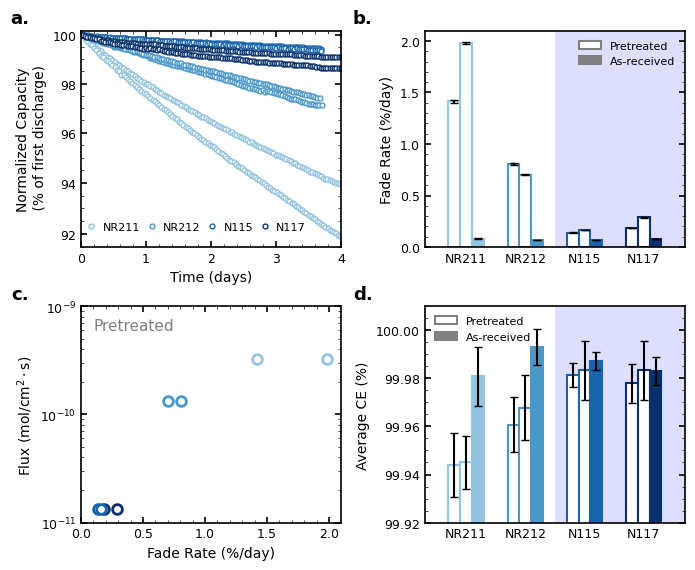

In [17]:
# Nafion 211, 211, 212, 212, 115, 115, 117, 117
thick = [25, 25, 50, 50, 125, 125, 183, 183]
all_mems = ['NR211', 'NR211', 'NR212', 'NR212', 'N115', 'N115', 'N117', 'N117']

exp_loc1 = cycle_data_path # 117, 211
ff1 = ["2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-02_out.csv",
       "2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-06_out.csv",
       "2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-03_out.csv",
       "2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-07_out.csv",
      ]
#
exp_loc2 = cycle_data_path # 115, 212
ff2 = ["2023-03-31_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-02_out.csv",
       "2023-03-31_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-06_out.csv",
       "2023-03-31_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-03_out.csv",
       "2023-03-31_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-07_out.csv",
      ]

all_data = [exp_loc1 + ff1[2], exp_loc1 + ff1[3], exp_loc2 + ff2[2], exp_loc2 + ff2[3],
            exp_loc2 + ff2[0], exp_loc2 + ff2[1], exp_loc1 + ff1[0], exp_loc1 + ff1[1]
           ]
#############################################
fig = plt.figure(figsize=(double_width, double_width*0.8))
ax1 = plt.subplot(2, 2, 1) # norm cap vs time
ax2 = plt.subplot(2, 2, 2) # fade rate v name
ax3 = plt.subplot(2, 2, 3) # flux v fade rate
ax4 = plt.subplot(2, 2, 4) # CE v name

CE_skip = 2
start_fit = 5

barWidth = 0.3

c_map = plt.cm.Blues([0.4, 0.6, 0.8, 1.0])
c_map2 = [x for pair in zip(c_map,c_map) for x in pair]

c_map = plt.cm.Blues([0.4, 0.6, 0.8, 1.0])

poach_fades = []
poach_fades_err = []
poach_avg_CE = []
poach_CE_std = []

for idx,filepath in enumerate(all_data):
    df = pd.read_csv(filepath)
    charge_time, discharge_time, discharge, charge = get_cycle_data(df)
    CE_time, CE_vals = get_CE_vals(charge, discharge, discharge_time)
    plot_label = all_mems[idx]
    poach_avg_CE.append(np.average(CE_vals[10:]))
    poach_CE_std.append(np.std(CE_vals[10:]))

    # 1 norm cap vs time
    norm_cap = (discharge / discharge[0])*100
    ax1.plot(discharge_time, norm_cap, 'o', color=c_map2[idx],
             markerfacecolor='white', markersize=3.5, label=plot_label)

    # 2 fade rate vs name
    slope, intercept, r2, slope_conf_int, inter_conf_int, predictions, slope_error_CI, RSE = data_fitting(
        discharge_time[start_fit:], np.log(discharge[start_fit:]))
    fade = slope*-100
    print(f"cell {plot_label}: fade rate: {fade:.3f} +/- {slope_error_CI*100:.3f} %/day")
    poach_fades.append(fade)
    poach_fades_err.append(slope_error_CI*100)       
#
# bar plots setup
bar_W = 0.2
bar_labels = all_mems[::2]

# 2 fade v name
bar_data = [poach_fades[::2], poach_fades[1::2], AR_fades]
bar_data_err = [poach_fades_err[::2], poach_fades_err[1::2], AR_fades_err]
x = np.arange(len(bar_labels))
multy = 0

f_color = []
for idx,(d_set, d_err) in enumerate(zip(bar_data, bar_data_err)):
    offset = bar_W*multy
    if idx == 2:
        ax2.bar(x + offset, d_set, color=c_map, width=bar_W,  edgecolor=c_map,
                yerr=d_err, capsize=3, ecolor='k', linewidth=1.5)
    else:
        ax2.bar(x + offset, d_set, color=c_map, width=bar_W,  edgecolor=c_map, facecolor='white',
                yerr=d_err, capsize=3, ecolor='k', linewidth=1.5)
    multy +=1
ax2.set_xticks(x + bar_W, bar_labels)   
    
#############
# 3 flux vs fade rate
flux_poach = [x for pair in zip(poach_flux,poach_flux) for x in pair]
zz = [1,1,1,1,2,2,1,1]
for i,(x,y,z) in enumerate(zip(poach_fades, flux_poach, zz)):
    ax3.plot(x, y, 'o', color=c_map2[i], markersize=7, markerfacecolor='white', markeredgewidth=2, zorder=z)
ax3.set_yscale('log')

###########################################
# 4 CE vs membrane name
bar_data4 = [poach_avg_CE[::2], poach_avg_CE[1::2], AR_avg_CE]
bar_data4_err = [poach_CE_std[::2], poach_CE_std[1::2], AR_CE_std]
multy = 0
x = np.arange(len(bar_labels))

for idx,(d_set, d_err) in enumerate(zip(bar_data4, bar_data4_err)):
    offset = bar_W*multy
    if idx == 2:
        ax4.bar(x + offset, d_set, color=c_map, width=bar_W,  edgecolor=c_map,
                yerr=d_err, capsize=3, ecolor='k', linewidth=1.5)
    else:
        ax4.bar(x + offset, d_set, color=c_map, width=bar_W,  edgecolor=c_map, facecolor='white',
                yerr=d_err, capsize=3, ecolor='k', linewidth=1.5)
    multy +=1
ax4.set_xticks(x + bar_W, bar_labels)

##############################################
ax1.set_yscale('log')
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Normalized Capacity\n (% of first discharge)')
ax1.set_ylim([91.5,100.2])
ax1.set_xlim([0,4])
ax1.set_yticks([92, 94, 96, 98, 100])
ax1.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax1.yaxis.set_minor_formatter(mticker.NullFormatter())
min_ticks = [i for i in np.arange(90,100.1, step=0.5)]
ax1.yaxis.set_minor_locator(mticker.FixedLocator(min_ticks))


handles,labels = ax1.get_legend_handles_labels()
handles = [handles[0],handles[2],handles[4],handles[6]]
labels = [labels[0],labels[2],labels[4],labels[6]]
ax1.legend(handles,labels,loc=(-0.02,0.05),frameon=False, ncols=4, handletextpad=0.01, columnspacing=0.05)

ax2.set_ylabel('Fade Rate (%/day)')
ax2.set_ylim([0,2.1])
ax2.set_xlim(-0.5,3.9)
ax2.tick_params(axis='x', which='both', bottom=False, top=False)

# hacky way to get legend
circ1 = mpatches.Patch(edgecolor ='grey', facecolor='white', label='Pretreated', linewidth=1.5)
circ2 = mpatches.Patch(edgecolor ='grey', facecolor='gray', label='As-received', linewidth=1.5)
ax2.legend(handles=[circ1,circ2,], frameon=False)
ax4.legend(handles=[circ1,circ2,], frameon=False)

ax3.set_ylabel(r'Flux ($\mathregular{mol/{cm}^2\cdot}$s)')
ax3.set_xlabel('Fade Rate (%/day)')
ax3.set_ylim(1e-11,1e-9)
ax3.set_xlim(0,2.1)
ax3.text(0.1, 6e-10, 'Pretreated', color='gray', fontsize=11)

ax4.set_ylabel('Average CE (%)')
ax4.set_ylim([99.92,100.01])
ax4.set_xlim(-0.5,3.9)
ax4.set_yticks([99.92, 99.94, 99.96, 99.98, 100])
ax4.tick_params(axis='x', which='both', bottom=False, top=False)
ax4.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# shading for membrane family
region_y = np.linspace(0,200) 
ax2.fill_betweenx(y=region_y, x1=1.7, x2=4, facecolor='blue', alpha=0.13, zorder=0)
ax4.fill_betweenx(y=region_y, x1=1.7, x2=4, facecolor='blue', alpha=0.13, zorder=0)

fig.tight_layout()

ax1.text(-0.2, 1.1, 'a.', transform=ax1.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax2.text(-0.2, 1.1, 'b.', transform=ax2.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax3.text(-0.2, 1.1, 'c.', transform=ax3.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax4.text(-0.2, 1.1, 'd.', transform=ax4.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')

# Zero-d model useful experiment-derived parameters

In [38]:
# NR211, NR212, N115, N117
thickness = [25, 50, 125, 183]                    # microns
poach_perm = [8.3e-9,  6.7e-9,  1.6e-9,  2.3e-9]  # cm^2/s
ohm_resist = [0.035, 0.038, 0.060, 0.075]         # ohms

AR_perm = [4.5e-11, 4.0e-11, 2.3e-10, 2.3e-10]    # cm^2/s
AR_ohm_resist = [0.033, 0.046, 0.066, 0.088]      # ohms

# Figure 4

In [39]:
# for plotting
fig_b_xvals = []
fig_b_yvals = []

fig_c_time_cycles = []
fig_c_timesteps = []
fig_c_disch_cap = []
fig_c_time_charge = []
fig_c_charge_cap = []

fig_c_voltage = []
fig_c_cls_conc_ox = []
fig_c_cls_conc_red = []
fig_c_ncls_conc_ox = []
fig_c_ncls_conc_red = []
fig_c_cls_conc_dimer = []
fig_c_ncls_conc_dimer = []

# set chemical degradation rate 
chem_deg = ChemicalDegradationReduced(rate_order=1, rate_constant=1.0e-8)

k_for = 0.03
k_back = k_for / 75

# timing
start_t = time()

for idx, (m,p,r) in enumerate(zip(thickness, poach_perm, ohm_resist)):
    dimer_cls = Dimerization(forward_rate_constant=k_for, backward_rate_constant=k_back)
    dimer_ncls = Dimerization(forward_rate_constant=k_for, backward_rate_constant=k_back)

    multi_cls = MultiDegradationMechanism([chem_deg, dimer_cls])
    multi_ncls = MultiDegradationMechanism([chem_deg, dimer_ncls])

    cell = ZeroDModel(volume_cls=0.005,      # L
                      volume_ncls=0.010,     # L
                      c_ox_cls=0.05,         # M
                      c_red_cls=0.05,        # M
                      c_ox_ncls=0.05,        # M
                      c_red_ncls=0.05,       # M
                      ocv_50_soc=0.0,        # V
                      resistance=r,          # ohms
                      k_0_cls=1e-3,          # cm/s
                      k_0_ncls=1e-3,         # cm/s
                      time_step=0.05,        # sec
                      num_electrons_cls=2,   # electrons
                      num_electrons_ncls=2,  # electrons
                      )

    protocol = ConstantCurrentConstantVoltage(voltage_limit_charge=0.2,
                                              voltage_limit_discharge=-0.2,
                                              current_cutoff_charge=0.005,
                                              current_cutoff_discharge=-0.005,
                                              current=0.05)
    # crossover
    cross = Crossover(membrane_thickness=m, permeability_ox=p, permeability_red=p)
    
    # putting it all together
    all_results = protocol.run(cell_model=cell,
                               duration=90000,  # cycle time to simulate (s)
                               cls_degradation=multi_cls,
                               ncls_degradation=multi_ncls,
                               crossover=cross,
                               )
    d_time = [t/86400 for t in all_results.discharge_cycle_time]  # now time is in days
    disch = all_results.discharge_cycle_capacity
    norm_cap_discharge = [(i / disch[0]) * 100 for i in disch]
    
    slope, *_ = data_fitting(d_time[1:], np.log(disch[1:]))
    print(f"membrane thickness: {m}um, fade rate: {slope*-100:.3f}%/day, 1st discharge: {disch[0]:.1f} C")
    
    # for later plotting
    fig_b_xvals.append(d_time)
    fig_b_yvals.append(norm_cap_discharge)

    # Nafion 211 for fig c
    if idx == 0:
        fig_c_time_cycles.append(d_time)
        fig_c_timesteps.append([t/86400 for t in all_results.step_time])
        fig_c_disch_cap.append(disch)
        
        fig_c_time_charge.append([t/86400 for t in all_results.charge_cycle_time])
        fig_c_charge_cap.append(all_results.charge_cycle_capacity)
        
        
        fig_c_voltage.append(all_results.cell_v)
        fig_c_cls_conc_ox.append(all_results.c_ox_cls)
        fig_c_cls_conc_red.append(all_results.c_red_cls)
        fig_c_ncls_conc_ox.append(all_results.c_ox_ncls)
        fig_c_ncls_conc_red.append(all_results.c_red_ncls) 
        fig_c_cls_conc_dimer.append(all_results.c_products_cls['c_dimer'])
        fig_c_ncls_conc_dimer.append(all_results.c_products_ncls['c_dimer'])        
#
end_t = time()
total_min = (end_t - start_t) / 60
print(f"elapsed time: {total_min:.1f} min")

90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 25um, fade rate: 5.950%/day, 1st discharge: 72.3 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 50um, fade rate: 2.487%/day, 1st discharge: 71.8 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 125um, fade rate: 0.274%/day, 1st discharge: 71.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 183um, fade rate: 0.270%/day, 1st discharge: 71.5 C
elapsed time: 8.6 min


Text(-0.17, 1.35, 'c.')

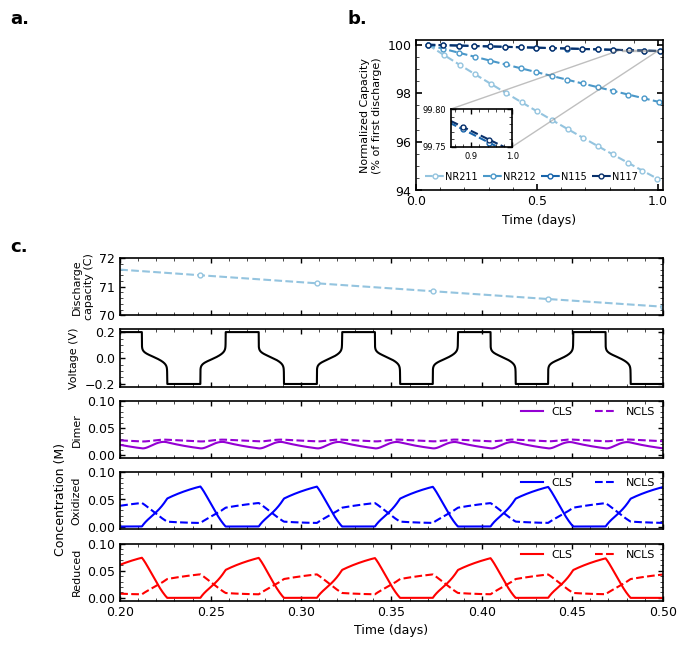

In [40]:
# Figure 4, split up so different spacing can be done for top vs shared bottom plots
gs_top = gridspec.GridSpec(7, 2, top=1)
gs_base = gridspec.GridSpec(7, 2, hspace=0.25)
fig = plt.figure(figsize=(double_width, double_width*0.9))

# Top (unshared) axes
ax1 = fig.add_subplot(gs_top[0:2,0])  # blank
ax2 = fig.add_subplot(gs_top[0:2,1])  # cap vs time, all membranes

ax1.axis('off')

# The four shared axes
ax3 = fig.add_subplot(gs_base[2, :])             # 211, cap
ax4 = fig.add_subplot(gs_base[3, :], sharex=ax3) # 211, voltage
ax5 = fig.add_subplot(gs_base[4, :], sharex=ax3) # 211, dimer conc cls/ncls
ax6 = fig.add_subplot(gs_base[5, :], sharex=ax3) # 211, ox conc cls/ncls
ax7 = fig.add_subplot(gs_base[6, :], sharex=ax3) # 211, red conc cls/ncls

# Hide shared x-tick labels
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), visible=False)
plt.setp(ax6.get_xticklabels(), visible=False)

lbs = ["NR211", "NR212", "N115", "N117"]
c_map = plt.cm.Blues([0.4, 0.6, 0.8, 1.0])

skip = 50

ax2in = ax2.inset_axes([0.14, 0.29, 0.25, 0.25]) # x0,y0, width, height. of lower left corner

for idx,t in enumerate(thickness):
    ax2.plot(fig_b_xvals[idx], fig_b_yvals[idx], 'o--', color=c_map[idx],
             markerfacecolor='white', markersize=3.5, label=lbs[idx])
    ax2in.plot(fig_b_xvals[idx], fig_b_yvals[idx], 'o--', color=c_map[idx],
             markerfacecolor='white', markersize=3.5, label=lbs[idx])
#
ax2in.tick_params(axis='both', labelsize=6)
ax2in.set_xlim(0.85, 1.0)
ax2in.set_ylim(99.75, 99.8)
ax2in.tick_params('both', length=3.5, width=1, which='major')
ax2in.set_xticks([0.9, 1.0])
ax2in.set_yticks([99.75, 99.8])
ax2.indicate_inset_zoom(ax2in)
ax2.set_xticks([0.0, 0.5, 1.0])
ax2.legend(frameon=False, ncols=4, handletextpad=0.1, columnspacing=0.5, loc='lower left', fontsize=7)
#
ax2.set_xlabel("Time (days)", fontsize=9)
ax2.set_ylabel("Normalized Capacity\n(% of first discharge)", fontsize=8)
ax2.set_xlim(0,1.02)
ax2.set_ylim(94,100.2)

# naf 211 data only

# capacity
ax3.plot(fig_c_time_cycles[0], fig_c_disch_cap[0], 'o--', color=c_map[0], markerfacecolor='white', markersize=3.5)
ax3.set_ylabel("Discharge\ncapacity (C)", fontsize=8)
ax3.set_ylim([70, 72])

# cell voltage
ax4.plot(fig_c_timesteps[0][::skip], fig_c_voltage[0][::skip], 'k')
ax4.set_ylabel("Voltage (V)", fontsize=8)

fig_c_ncls_conc_dimer

# dimer concentrations
ax5.plot(fig_c_timesteps[0][::skip], fig_c_cls_conc_dimer[0][::skip], 'darkviolet', linestyle='-', label='CLS')
ax5.plot(fig_c_timesteps[0][::skip], fig_c_ncls_conc_dimer[0][::skip], 'darkviolet', linestyle='--', label='NCLS')
ax5.set_ylim(-0.005,0.1)
ax5.set_ylabel("Dimer", fontsize=8)
ax5.set_yticks([0.0, 0.05, 0.1])
ax5.legend(frameon=False, ncols=2, loc=(0.73,0.64))

# oxidized concentrations
ax6.plot(fig_c_timesteps[0][::skip], fig_c_cls_conc_ox[0][::skip], 'b', label='CLS')
ax6.plot(fig_c_timesteps[0][::skip], fig_c_ncls_conc_ox[0][::skip], 'b--', label='NCLS')
ax6.set_ylim(-0.005,0.1)
ax6.set_ylabel("Oxidized", fontsize=8)
ax6.set_yticks([0.0, 0.05, 0.1])
ax6.legend(frameon=False, ncols=2, loc=(0.73,0.64))

# reduced concentrations
ax7.plot(fig_c_timesteps[0][::skip], fig_c_cls_conc_red[0][::skip], 'r', label='CLS')
ax7.plot(fig_c_timesteps[0][::skip], fig_c_ncls_conc_red[0][::skip], 'r--', label='NCLS')
ax7.set_ylim(-0.005,0.1)
ax7.set_ylabel("Reduced", fontsize=8)
ax7.set_yticks([0.0, 0.05, 0.1])
ax7.legend(frameon=False, ncols=2, loc=(0.73,0.64))

ax7.set_xlabel("Time (days)", fontsize=9)

# set x range for shared plots
ax7.set_xlim([0.2,0.5])

# change tick lengths a bit
ax3.tick_params('both', length=3.5, width=1, which='major')
ax4.tick_params('both', length=3.5, width=1, which='major')
ax5.tick_params('both', length=3.5, width=1, which='major')
ax6.tick_params('both', length=3.5, width=1, which='major')
ax7.tick_params('both', length=3.5, width=1, which='major')
fig.text(0.03, 0.27, 'Concentration (M)', va='center', rotation='vertical', fontsize=9)

ax1.text(-0.37, 1.2, 'a.', transform=ax1.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax2.text(-0.2, 1.2, 'b.', transform=ax2.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax3.text(-0.17, 1.35, 'c.', transform=ax3.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')

# Figure 5

In [41]:
# get 211 and 117 values only
thik = [thickness[0], thickness[3]]
perm = [poach_perm[0], poach_perm[3]]
res = [ohm_resist[0], ohm_resist[3]]

# rate constants to use
fig5_k_dimer = 75.0      # 1/sec
fig5_k_forward = 0.03    # 1/(M*sec)
fig5_k_chemdeg = 1.0e-8  # 1/sec

### data for subplot A

In [43]:
fig_a_xvals_211 = []
fig_a_yvals_211 = []
fig_a_xvals_117 = []
fig_a_yvals_117 = []
##########################################
chem_deg = ChemicalDegradationReduced(rate_order=1, rate_constant=fig5_k_chemdeg)
k_dimer = [0, fig5_k_dimer, 100]

# timing
start_t = time()
for k in k_dimer:
    for idx, (m,p,r) in enumerate(zip(thik, perm, res)):
        if k == 0:
            multi_cls = chem_deg
            multi_ncls = chem_deg
        else:
            k_back = fig5_k_forward / k
            dimer_cls = Dimerization(forward_rate_constant=fig5_k_forward, backward_rate_constant=k_back)
            dimer_ncls = Dimerization(forward_rate_constant=fig5_k_forward, backward_rate_constant=k_back)

            multi_cls = MultiDegradationMechanism([chem_deg, dimer_cls])
            multi_ncls = MultiDegradationMechanism([chem_deg, dimer_ncls])

        cell = ZeroDModel(volume_cls=0.005,      # L
                          volume_ncls=0.010,     # L
                          c_ox_cls=0.05,         # M
                          c_red_cls=0.05,        # M
                          c_ox_ncls=0.05,        # M
                          c_red_ncls=0.05,       # M
                          ocv_50_soc=0.0,        # V
                          resistance=r,          # ohms
                          k_0_cls=1e-3,          # cm/s
                          k_0_ncls=1e-3,         # cm/s
                          time_step=0.05,        # sec
                          num_electrons_cls=2,   # electrons
                          num_electrons_ncls=2,  # electrons
                          )

        protocol = ConstantCurrentConstantVoltage(voltage_limit_charge=0.2,
                                                  voltage_limit_discharge=-0.2,
                                                  current_cutoff_charge=0.005,
                                                  current_cutoff_discharge=-0.005,
                                                  current=0.05)
        # crossover
        cross = Crossover(membrane_thickness=m, permeability_ox=p, permeability_red=p)

        # putting it all together
        all_results = protocol.run(cell_model=cell,
                                   duration=90000,  # cycle time to simulate (s)
                                   cls_degradation=multi_cls,
                                   ncls_degradation=multi_ncls,
                                   crossover=cross,
                                   )
        d_time = [t/86400 for t in all_results.discharge_cycle_time]  # now time is in days
        disch = all_results.discharge_cycle_capacity
        norm_cap_discharge = [(i / disch[0]) * 100 for i in disch]

        slope, *_ = data_fitting(d_time[1:], np.log(disch[1:]))
        print(f"membrane thickness: {m}um, k_dim={k}, fade rate: {slope*-100:.3f}%/day, 1st discharge: {disch[0]:.1f} C")

        # for later plotting
        if idx == 0:
            fig_a_xvals_211.append(d_time)
            fig_a_yvals_211.append(disch)
        else:
            fig_a_xvals_117.append(d_time)
            fig_a_yvals_117.append(disch)
#
end_t = time()
total_min = (end_t - start_t) / 60
print(f"elapsed time: {total_min:.1f} min")

90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 25um, k_dim=0, fade rate: 0.043%/day, 1st discharge: 96.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 183um, k_dim=0, fade rate: 0.043%/day, 1st discharge: 96.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 25um, k_dim=75.0, fade rate: 5.950%/day, 1st discharge: 72.3 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 183um, k_dim=75.0, fade rate: 0.270%/day, 1st discharge: 71.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 25um, k_dim=100, fade rate: 6.230%/day, 1st discharge: 64.1 C
90000 sec of cycling, time steps: 0

### data for subplot B
#### (increase simulation time to obtain Figure S15)

In [44]:
fig_b_xvals_211 = []
fig_b_yvals_211 = []
fig_b_xvals_117 = []
fig_b_yvals_117 = []

chem_deg = ChemicalDegradationReduced(rate_order=1, rate_constant=fig5_k_chemdeg)

perm_multi_ox = [1, 5, 1]
perm_multi_red = [1, 1, 5]
# timing
start_t = time()
for px_o,px_r in zip(perm_multi_ox, perm_multi_red):
    for idx, (m,p,r) in enumerate(zip(thik, perm, res)):

        cell = ZeroDModel(volume_cls=0.005,      # L
                          volume_ncls=0.010,     # L
                          c_ox_cls=0.05,         # M
                          c_red_cls=0.05,        # M
                          c_ox_ncls=0.05,        # M
                          c_red_ncls=0.05,       # M
                          ocv_50_soc=0.0,        # V
                          resistance=r,          # ohms
                          k_0_cls=1e-3,          # cm/s
                          k_0_ncls=1e-3,         # cm/s
                          time_step=0.05,        # sec
                          num_electrons_cls=2,   # electrons
                          num_electrons_ncls=2,  # electrons
                          )

        protocol = ConstantCurrentConstantVoltage(voltage_limit_charge=0.2,
                                                  voltage_limit_discharge=-0.2,
                                                  current_cutoff_charge=0.005,
                                                  current_cutoff_discharge=-0.005,
                                                  current=0.05)
        # crossover
        
        cross = Crossover(membrane_thickness=m,
                          permeability_ox=p*px_o,
                          permeability_red=p*px_r,
                         )
        
        # putting it all together
        all_results = protocol.run(cell_model=cell,
                                   duration=90000,  # cycle time to simulate (s)
                                   cls_degradation=chem_deg,
                                   ncls_degradation=chem_deg,
                                   crossover=cross,
                                   )
        d_time = [t/86400 for t in all_results.discharge_cycle_time]  # now time is in days
        disch = all_results.discharge_cycle_capacity
        norm_cap_discharge = [(i / disch[0]) * 100 for i in disch]

        slope, *_ = data_fitting(d_time[1:], np.log(disch[1:]))
        print(f"membrane thickness: {m}um, P_o X={px_o} P_r X={px_r}, fade rate: {slope*-100:.3f}%/day, 1st discharge: {disch[0]:.1f} C")

        # for later plotting
        if idx == 0:
            fig_b_xvals_211.append(d_time)
            fig_b_yvals_211.append(disch)
        else:
            fig_b_xvals_117.append(d_time)
            fig_b_yvals_117.append(disch)
#
end_t = time()
total_min = (end_t - start_t) / 60
print(f"elapsed time: {total_min:.1f} min")

90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 25um, P_o X=1 P_r X=1, fade rate: 0.043%/day, 1st discharge: 96.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 183um, P_o X=1 P_r X=1, fade rate: 0.043%/day, 1st discharge: 96.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 25um, P_o X=5 P_r X=1, fade rate: 0.353%/day, 1st discharge: 97.0 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 183um, P_o X=5 P_r X=1, fade rate: 0.043%/day, 1st discharge: 96.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 25um, P_o X=1 P_r X=5, fade rate: -0.265%/day, 1st discharge: 96.1 C
90

### data for subplot C

In [45]:
fig_c_xvals_211 = []
fig_c_yvals_211 = []
fig_c_xvals_117 = []
fig_c_yvals_117 = []

k_back = fig5_k_forward / fig5_k_dimer

dimer_cls = Dimerization(forward_rate_constant=fig5_k_forward, backward_rate_constant=k_back)
dimer_ncls = Dimerization(forward_rate_constant=fig5_k_forward, backward_rate_constant=k_back)

k_chem = [0, fig5_k_chemdeg, fig5_k_chemdeg*10]

# timing
start_t = time()
for k in k_chem:
    for idx, (m,p,r) in enumerate(zip(thik, perm, res)):
        if k == 0:
            multi_cls = dimer_cls
            multi_ncls = dimer_ncls
        else:
            chem_deg = ChemicalDegradationReduced(rate_order=1, rate_constant=k)

            multi_cls = MultiDegradationMechanism([chem_deg, dimer_cls])
            multi_ncls = MultiDegradationMechanism([chem_deg, dimer_ncls])

        cell = ZeroDModel(volume_cls=0.005,      # L
                          volume_ncls=0.010,     # L
                          c_ox_cls=0.05,         # M
                          c_red_cls=0.05,        # M
                          c_ox_ncls=0.05,        # M
                          c_red_ncls=0.05,       # M
                          ocv_50_soc=0.0,        # V
                          resistance=r,          # ohms
                          k_0_cls=1e-3,          # cm/s
                          k_0_ncls=1e-3,         # cm/s
                          time_step=0.05,        # sec
                          num_electrons_cls=2,   # electrons
                          num_electrons_ncls=2,  # electrons
                          )

        protocol = ConstantCurrentConstantVoltage(voltage_limit_charge=0.2,
                                                  voltage_limit_discharge=-0.2,
                                                  current_cutoff_charge=0.005,
                                                  current_cutoff_discharge=-0.005,
                                                  current=0.05)
        # crossover
        cross = Crossover(membrane_thickness=m, permeability_ox=p, permeability_red=p)

        # putting it all together
        all_results = protocol.run(cell_model=cell,
                                   duration=90000,  # cycle time to simulate (s)
                                   cls_degradation=multi_cls,
                                   ncls_degradation=multi_ncls,
                                   crossover=cross,
                                   )
        d_time = [t/86400 for t in all_results.discharge_cycle_time]  # now time is in days
        disch = all_results.discharge_cycle_capacity
        norm_cap_discharge = [(i / disch[0]) * 100 for i in disch]

        slope, *_ = data_fitting(d_time[1:], np.log(disch[1:]))
        print(f"membrane thickness: {m}um, k_chem={k}, fade rate: {slope*-100:.3f}%/day, 1st discharge: {disch[0]:.1f} C")

        # for later plotting
        if idx == 0:
            fig_c_xvals_211.append(d_time)
            fig_c_yvals_211.append(disch)
        else:
            fig_c_xvals_117.append(d_time)
            fig_c_yvals_117.append(disch)
#
end_t = time()
total_min = (end_t - start_t) / 60
print(f"elapsed time: {total_min:.1f} min")

90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 25um, k_chem=0, fade rate: 5.914%/day, 1st discharge: 72.3 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 183um, k_chem=0, fade rate: 0.233%/day, 1st discharge: 71.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 25um, k_chem=1e-08, fade rate: 5.950%/day, 1st discharge: 72.3 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 183um, k_chem=1e-08, fade rate: 0.270%/day, 1st discharge: 71.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 25um, k_chem=1e-07, fade rate: 6.280%/day, 1st discharge: 72.3 C
90000 sec of cycling, time

### data for subplot D

In [46]:
fig_d_xvals_211 = []
fig_d_yvals_211 = []
fig_d_xvals_117 = []
fig_d_yvals_117 = []

# k_chem values are set above in fig C

# p_ox is > p_red
p_ox_multiplier = 5

# timing
start_t = time()
for k in k_chem:
    for idx, (m,p,r) in enumerate(zip(thik, perm, res)):
   
        cell = ZeroDModel(volume_cls=0.005,      # L
                          volume_ncls=0.010,     # L
                          c_ox_cls=0.05,         # M
                          c_red_cls=0.05,        # M
                          c_ox_ncls=0.05,        # M
                          c_red_ncls=0.05,       # M
                          ocv_50_soc=0.0,        # V
                          resistance=r,          # ohms
                          k_0_cls=1e-3,          # cm/s
                          k_0_ncls=1e-3,         # cm/s
                          time_step=0.05,        # sec
                          num_electrons_cls=2,   # electrons
                          num_electrons_ncls=2,  # electrons
                          )

        protocol = ConstantCurrentConstantVoltage(voltage_limit_charge=0.2,
                                                  voltage_limit_discharge=-0.2,
                                                  current_cutoff_charge=0.005,
                                                  current_cutoff_discharge=-0.005,
                                                  current=0.05)
        # crossover
        cross = Crossover(membrane_thickness=m,
                          permeability_ox=p*p_ox_multiplier,
                          permeability_red=p,
                         )

        # putting it all together
        if k == 0:
            all_results = protocol.run(cell_model=cell,
                                       duration=90000,  # cycle time to simulate (s)
                                       crossover=cross,
                                      )
        else:
            chem_deg = ChemicalDegradationReduced(rate_order=1, rate_constant=k)
            all_results = protocol.run(cell_model=cell,
                                       duration=90000,  # cycle time to simulate (s)
                                       cls_degradation=chem_deg,
                                       ncls_degradation=chem_deg,
                                       crossover=cross,
                                       )
        #
        d_time = [t/86400 for t in all_results.discharge_cycle_time]  # now time is in days
        disch = all_results.discharge_cycle_capacity
        norm_cap_discharge = [(i / disch[0]) * 100 for i in disch]

        slope, *_ = data_fitting(d_time[1:], np.log(disch[1:]))
        print(f"membrane thickness: {m}um, k_chem={k}, fade rate: {slope*-100:.3f}%/day, 1st discharge: {disch[0]:.1f} C")

        # for later plotting
        if idx == 0:
            fig_d_xvals_211.append(d_time)
            fig_d_yvals_211.append(disch)
        else:
            fig_d_xvals_117.append(d_time)
            fig_d_yvals_117.append(disch)
#
end_t = time()
total_min = (end_t - start_t) / 60
print(f"elapsed time: {total_min:.1f} min")

90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 25um, k_chem=0, fade rate: 0.324%/day, 1st discharge: 97.0 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 183um, k_chem=0, fade rate: 0.001%/day, 1st discharge: 96.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 25um, k_chem=1e-08, fade rate: 0.353%/day, 1st discharge: 97.0 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 183um, k_chem=1e-08, fade rate: 0.043%/day, 1st discharge: 96.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
membrane thickness: 25um, k_chem=1e-07, fade rate: 0.621%/day, 1st discharge: 96.9 C
90000 sec of cycling, time

### make Figure 5
#### (plot discharge capacity instead of normalized capacity to obtain Figure S14)

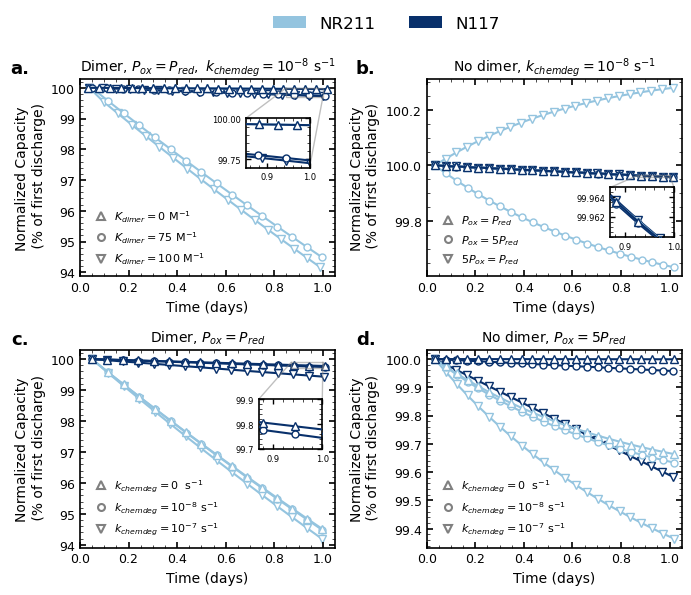

In [47]:
# setup subplots
fig = plt.figure(figsize=(double_width, double_width*0.8))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3, sharex=ax1)
ax4 = plt.subplot(2, 2, 4, sharex=ax2)

c_map = plt.cm.Blues([0.4, 1.0]) # 211, 117
marks = ['^', 'o', 'v']
m_size = [6, 5, 6]
zz = [3,2,1]

# figure A, Naf211
ax1in = ax1.inset_axes([0.65, 0.55, 0.25, 0.25]) # x0,y0, width, height. of lower left corner

for idx,(x,y) in enumerate(zip(fig_a_xvals_211, fig_a_yvals_211)): 
    ax1.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[0], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])
    ax1in.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[0], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])
    
# figure A, Naf117
for idx,(x,y) in enumerate(zip(fig_a_xvals_117, fig_a_yvals_117)): 
    ax1.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[1], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])
    ax1in.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[1], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])
#
ax1in.tick_params(axis='both', labelsize=6)
ax1in.set_xlim(0.85, 1.0)
ax1in.set_ylim(99.7, 100)
ax1in.tick_params('both', length=3.5, width=1, which='major')
ax1in.set_yticks([99.75, 100.0])
ax1.indicate_inset_zoom(ax1in)    
    
##############################################################
# figure B, Naf211
ax2in = ax2.inset_axes([0.72, 0.2, 0.25, 0.25]) # x0,y0, width, height. of lower left corner

for idx,(x,y) in enumerate(zip(fig_b_xvals_211, fig_b_yvals_211)): 
    ax2.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[0], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])
    ax2in.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[0], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])

    # figure B, Naf117
for idx,(x,y) in enumerate(zip(fig_b_xvals_117, fig_b_yvals_117)): 
    ax2.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[1], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])
    ax2in.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[1], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])
#
ax2in.tick_params(axis='both', labelsize=6)
ax2in.set_xlim(0.87, 1.0)
ax2in.set_ylim(99.96, 99.965)
ax2in.tick_params('both', length=3.5, width=1, which='major')
ax2in.set_yticks([99.962, 99.964])
ax2in.ticklabel_format(useOffset=False)
ax2.indicate_inset_zoom(ax2in)
    
#####################################################
# figure C, Naf211
ax3in = ax3.inset_axes([0.7, 0.5, 0.25, 0.25]) # x0,y0, width, height. of lower left corner

for idx,(x,y) in enumerate(zip(fig_c_xvals_211, fig_c_yvals_211)): 
    ax3.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[0], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])
    ax3in.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[0], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])

# figure C, Naf117
for idx,(x,y) in enumerate(zip(fig_c_xvals_117, fig_c_yvals_117)): 
    ax3.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[1], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])
    ax3in.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[1], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])
#
ax3in.tick_params(axis='both', labelsize=6)
ax3in.set_xlim(0.87, 1.0)
ax3in.set_ylim(99.7, 99.9)
ax3in.tick_params('both', length=3.5, width=1, which='major')
ax3in.ticklabel_format(useOffset=False)
ax3.indicate_inset_zoom(ax3in)

###########################################
# figure D, Naf211
for idx,(x,y) in enumerate(zip(fig_d_xvals_211, fig_d_yvals_211)): 
    ax4.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[0], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])

# figure D, Naf117
for idx,(x,y) in enumerate(zip(fig_d_xvals_117, fig_d_yvals_117)): 
    ax4.plot(x, [(i / y[0]) * 100 for i in y], color=c_map[1], linestyle='-', marker=marks[idx],
             markersize=m_size[idx], markerfacecolor='white', zorder=zz[idx])
#
ax1.set_ylabel('Normalized Capacity\n (% of first discharge)')
ax2.set_ylabel('Normalized Capacity\n (% of first discharge)')
ax3.set_ylabel('Normalized Capacity\n (% of first discharge)')
ax4.set_ylabel('Normalized Capacity\n (% of first discharge)')
ax1.set_xlabel('Time (days)')
ax2.set_xlabel('Time (days)')
ax3.set_xlabel('Time (days)')
ax4.set_xlabel('Time (days)')

ax1.set_xlim([0, 1.05])
ax2.set_xlim([0, 1.05])
ax3.set_xlim([0, 1.05])
ax4.set_xlim([0, 1.05])

ax1.set_title(f"Dimer, ${{P_{{ox}}=P_{{red}},~k_{{chemdeg}}=10^{{{int(np.log10(fig5_k_chemdeg))}}}~\mathrm{{s^{{-1}}}}}}$",
              fontsize=10)
ax2.set_title(f"No dimer, ${{k_{{chemdeg}}=10^{{{int(np.log10(fig5_k_chemdeg))}}}~\mathrm{{s^{{-1}}}}}}$",
              fontsize=10)
ax3.set_title('Dimer, ${P_{ox}=P_{red}}$',
              fontsize=10)
ax4.set_title(f"No dimer, ${{P_{{ox}}={p_ox_multiplier}P_{{red}}}}$",
              fontsize=10)

# hacky way to get legend
circ1 = mpatches.Patch(facecolor=c_map[0], label='NR211')
circ2 = mpatches.Patch(facecolor=c_map[1], label='N117')

fig.legend(handles=[circ1, circ2], bbox_to_anchor=(0.74, 1.07), ncols=2, fontsize=12, frameon=False)

# legend labels
figA_labs = [f"${{K_{{dimer}}= {int(i)}~\mathrm{{M^{{-1}}}}}}$" for i in k_dimer]

figB_labs = [f"${{ {i}P_{{ox}}={j}P_{{red}}}}$" for (i,j) in zip(['','',perm_multi_ox[1]], ['',perm_multi_red[2],''])]

figC_labs = ["${{k_{{chemdeg}}=0~~\mathrm{{s^{{-1}}}}}}$"]
figC_labs.extend([f"${{k_{{chemdeg}}=10^{{{int(np.log10(i))}}}~\mathrm{{s^{{-1}}}}}}$" for i in k_chem[1:]])

figD_labs = ["${{k_{{chemdeg}}=0~~\mathrm{{s^{{-1}}}}}}$"]
figD_labs.extend([f"${{k_{{chemdeg}}=10^{{{int(np.log10(i))}}}~\mathrm{{s^{{-1}}}}}}$" for i in k_chem[1:]])

legend_labs = [figA_labs, figB_labs, figC_labs, figD_labs]

for a,lbs in zip(fig.axes, legend_labs):
    line1 = Line2D([], [], color="white", marker='^', linestyle='none', markeredgecolor='gray', markerfacecolor="white", 
                   markersize=6, markeredgewidth=1.5, label=lbs[0])
    line2 = Line2D([], [], color="white", marker='o', linestyle='none', markeredgecolor='gray', markerfacecolor='white',  
                   markersize=5, markeredgewidth=1.5, label=lbs[1])
    line3 = Line2D([], [], color="white", marker='v', linestyle='none', markeredgecolor='gray', markerfacecolor='white', 
                   markersize=6, markeredgewidth=1.5, label=lbs[2])

    a.legend(handles=[line1, line2, line3], frameon=False, handletextpad=0.2)
#
ax1.text(-0.2, 1.1, 'a.', transform=ax1.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax2.text(-0.2, 1.1, 'b.', transform=ax2.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax3.text(-0.2, 1.1, 'c.', transform=ax3.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax4.text(-0.2, 1.1, 'd.', transform=ax4.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
fig.tight_layout()

# Supporting information

# Figure S7

Text(1.09, 1.03, 'd.')

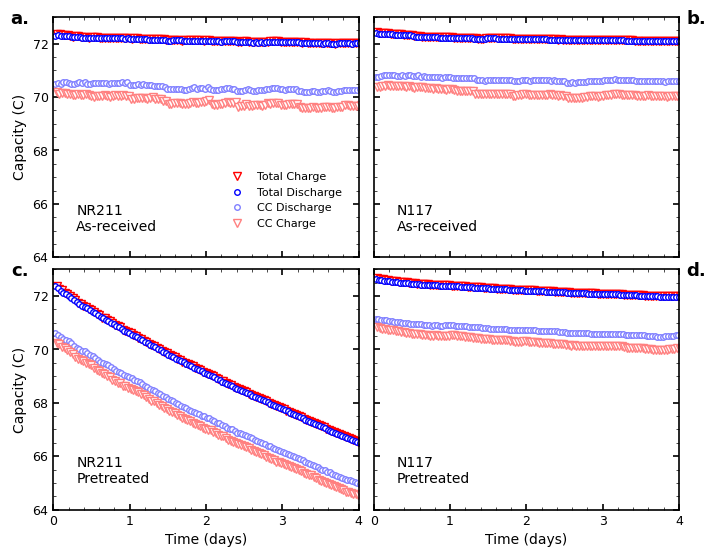

In [23]:
# CCCV breakdown
f = ["2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-01.csv",
     "2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-02.csv",
     "2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-04.csv",
     "2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-07.csv",
    ]
     
lb = ['NR211\nAs-received', 'N117\nPretreated', 'N117\nAs-received', 'NR211\nPretreated']

myorder = [0,2,3,1]
f_new = [f[i] for i in myorder]
lb_new = [lb[i] for i in myorder]

fig = plt.figure(figsize=(double_width, double_width*0.8))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2, sharey=ax1)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4, sharey=ax3)
ax = [ax1, ax2, ax3, ax4]

for idx,(file,a) in enumerate(zip(f_new,ax)):
    t_CC_c, CC_c, t_c, c, t_CC_d, CC_d, t_d, d = CCCV_cap.CCCV_breakdown_novonix(cycle_data_path, file).data_parse()

    if idx == 3:#1:
        a.plot(t_c[1:-1]/24, c[1:-1]*3600, 'rv', markerfacecolor='white', label='Total Charge')
    else:
        a.plot(t_c[1:]/24, c[1:]*3600, 'rv', markerfacecolor='white', label='Total Charge')
    
    a.plot(t_d/24, d*3600, 'bo', markersize=4, markerfacecolor='white', label='Total Discharge')
    if idx == 0:
        a.plot(t_CC_d[:-1]/24, CC_d[:-1]*3600, 'o', markersize=4, color='#8080ff', markerfacecolor='white', label='CC Discharge')
    else:
        a.plot(t_CC_d/24, CC_d*3600, 'o', markersize=4, color='#8080ff', markerfacecolor='white', label='CC Discharge')
    a.plot(t_CC_c/24, CC_c*3600, 'v', color='#ff8080', markerfacecolor='white', label='CC Charge')
    a.set_xlim(left=0, right=4)
#
ax1.set_ylabel('Capacity (C)')
ax1.legend(loc=(0.55,0.1), frameon=False)
ax1.set_ylim(64, 73)
ax1.set_yticks([64,66,68,70,72])
ax1.set_xticks([0,1,2,3,4])

ax2.set_xticks([0,1,2,3,4])

ax3.set_ylabel('Capacity (C)')
ax3.set_xlabel('Time (days)')
ax3.set_ylim(64, 73)
ax3.set_xticks([0,1,2,3,4])
ax3.set_yticks([64,66,68,70,72])

ax4.set_xlabel('Time (days)')
ax4.set_xticks([0,1,2,3,4])

plt.setp(ax2.get_yticklabels(), visible=False) 
plt.setp(ax4.get_yticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

# labels
ax1.text(0.3, 65, lb_new[0], fontsize=10, color='k')
ax2.text(0.3, 65, lb_new[1], fontsize=10, color='k')
ax3.text(0.3, 65, lb_new[2], fontsize=10, color='k')
ax4.text(0.3, 65, lb_new[3], fontsize=10, color='k')
    
fig.tight_layout()

plt.subplots_adjust(wspace=0.05, hspace=0.05)

ax1.text(-0.08, 1.03, 'a.', transform=ax1.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax2.text(1.09, 1.03, 'b.', transform=ax2.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax3.text(-0.08, 1.03, 'c.', transform=ax3.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax4.text(1.09, 1.03, 'd.', transform=ax4.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')

# Figure S8

Text(-0.2, 1.1, 'b.')

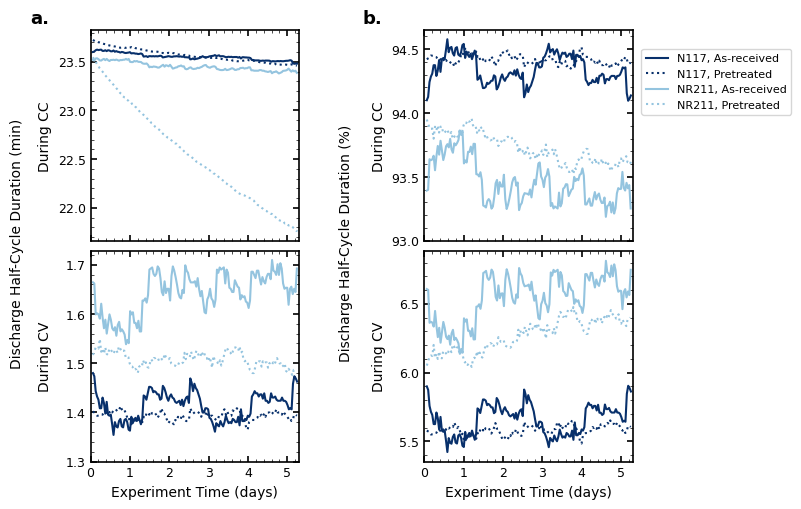

In [24]:
loc_1 = cycle_data_path
fff1 = "2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-04.csv" # 117, AR
fff2 = "2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-01.csv" # 211, AR

fff3 = "2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-02.csv" # 117, poached
fff4 = "2023-03-02_EMF_symcell_01M_AQDS_1MH2SO4_5mL10mL-03.csv" # 211, poached

lb = ['N117', 'NR211', 'N117', 'NR211']
extr = [', As-received', ', As-received', ', Pretreated', ', Pretreated']

c_map = plt.cm.Blues([1.0, 0.4, 1.0, 0.4])

f = [fff1, fff2, fff3, fff4]
fig = plt.figure(figsize=(double_width, double_width*0.8))
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3, sharex=ax1)
ax4 = plt.subplot(2, 2, 4, sharex=ax2)

lines = ['-', '-', ':', ':']
skip = 1
for idx,(fl,c) in enumerate(zip(f,c_map)):
    (len_CC_ch, len_CV_ch, len_CC_dis, len_CV_dis,
     time_CC_c, time_CV_c, time_CC_d, time_CV_d,
     frac_CC_ch, frac_CV_ch, frac_CC_dis, frac_CV_dis) = section_time_CCCV(loc_1, fl)

    ax1.plot(time_CC_d[skip:-1]/24, len_CC_dis[:-1], color=c, linestyle=lines[idx])
    ax3.plot(time_CV_d[skip:-1]/24, len_CV_dis[:-1], color=c, linestyle=lines[idx])
    
    ax2.plot(time_CC_d[skip:-1]/24, [i*100 for i in frac_CC_dis[:-1]], color=c, linestyle=lines[idx], label=lb[idx] + extr[idx])
    ax4.plot(time_CV_d[skip:-1]/24, [i*100 for i in frac_CV_dis[:-1]], color=c, linestyle=lines[idx])
#
plt.setp(ax1.get_xticklabels(), visible=False) 
plt.setp(ax2.get_xticklabels(), visible=False)
fig.text(0.02, 0.5, 'Discharge Half-Cycle Duration (min)', ha='center', va='center', rotation='vertical')
ax1.set_ylabel('During CC')

ax2.set_yticks([93.0, 93.5, 94.0, 94.5])

ax3.set_ylabel('During CV', labelpad=10)
ax3.set_xlabel('Experiment Time (days)')
ax3.set_yticks([1.3, 1.4, 1.5, 1.6, 1.7])


handles,labels = ax2.get_legend_handles_labels()
handles = [handles[0],handles[2],handles[1],handles[3]]
labels = [labels[0],labels[2],labels[1],labels[3]]
ax2.legend(handles,labels,loc=(1.04,0.6))

ax3.set_xticks([0,1,2,3,4,5])
ax3.set_xlim(0,5.3)

ax4.set_xticks([0,1,2,3,4,5])
ax4.set_xlim(0,5.3)
ax4.set_yticks([5.5, 6.0, 6.5])

fig.text(0.49, 0.5, 'Discharge Half-Cycle Duration (%)', ha='center', va='center', rotation='vertical')
ax2.set_ylabel('During CC')
ax4.set_ylabel('During CV', labelpad=10)
ax4.set_xlabel('Experiment Time (days)')
fig.subplots_adjust(wspace=0.6, hspace=0.05)

ax1.text(-0.2, 1.1, 'a.', transform=ax1.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax2.text(-0.2, 1.1, 'b.', transform=ax2.transAxes, fontsize=13, fontweight='bold', va='top', ha='right')

# Figure S9

90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
mem thic:25um, fade rate: 0.0699%/day
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
mem thic:50um, fade rate: 0.0513%/day
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
mem thic:125um, fade rate: 0.0705%/day
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
mem thic:183um, fade rate: 0.0600%/day
elapsed time: 8.8 min


Text(-0.2, 1.2, 'b.')

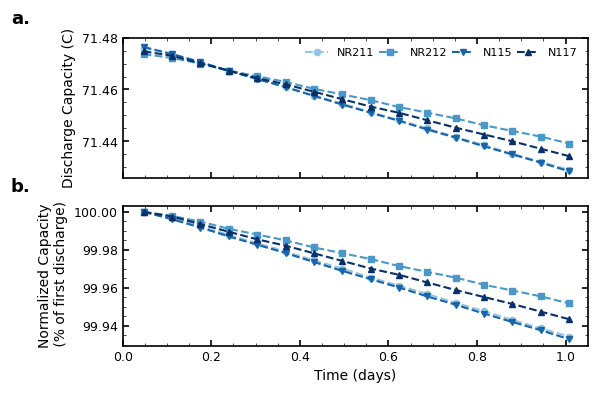

In [48]:
fig,ax = plt.subplots(nrows=2,ncols=1, sharex=True, figsize=(6,4))

labs = ['NR211', 'NR212', 'N115', 'N117']
c_map = plt.cm.Blues([0.4, 0.6, 0.8, 1.0])
marks = ['o', 's', 'v', '^']

chem_deg = ChemicalDegradationReduced(rate_order=1, rate_constant=1.0e-8)

k_for = 0.03
k_back = k_for/75

fig_data_x = []
fig_data_y = []

labs = ['NR211', 'NR212', 'N115', 'N117']
c_map = plt.cm.Blues([0.4, 0.6, 0.8, 1.0])
# timing
start_t = time()

for idx, (m,p,r) in enumerate(zip(thickness, AR_perm, AR_ohm_resist)):
    dimer_cls = Dimerization(forward_rate_constant=k_for, backward_rate_constant=k_back)
    dimer_ncls = Dimerization(forward_rate_constant=k_for, backward_rate_constant=k_back)

    multi_cls = MultiDegradationMechanism([chem_deg, dimer_cls])
    multi_ncls = MultiDegradationMechanism([chem_deg, dimer_ncls])

    cell = ZeroDModel(volume_cls=0.005,      # L
                      volume_ncls=0.010,     # L
                      c_ox_cls=0.05,         # M
                      c_red_cls=0.05,        # M
                      c_ox_ncls=0.05,        # M
                      c_red_ncls=0.05,       # M
                      ocv_50_soc=0.0,        # V
                      resistance=r,          # ohms
                      k_0_cls=1e-3,          # cm/s
                      k_0_ncls=1e-3,         # cm/s
                      time_step=0.05,        # sec
                      num_electrons_cls=2,   # electrons
                      num_electrons_ncls=2,  # electrons
                      )

    protocol = ConstantCurrentConstantVoltage(voltage_limit_charge=0.2,
                                              voltage_limit_discharge=-0.2,
                                              current_cutoff_charge=0.005,
                                              current_cutoff_discharge=-0.005,
                                              current=0.05)
    # putting it all together
    all_results = protocol.run(cell_model=cell,
                               duration=90000,  # cycle time to simulate (s)
                               cls_degradation=multi_cls,
                               ncls_degradation=multi_ncls,
                               crossover=Crossover(membrane_thickness=m, permeability_ox=p, permeability_red=p),
                               )
    
    d_time = [t/86400 for t in all_results.discharge_cycle_time]  # now time is in days
    fig_data_x.append(d_time)
    disch = all_results.discharge_cycle_capacity
    fig_data_y.append(disch)
    norm_cap_discharge = [(i / disch[0]) * 100 for i in disch]
    
    slope, *_ = data_fitting(d_time[1:], np.log(disch[1:]))
    print(f"mem thic:{m}um, fade rate: {slope*-100:.4f}%/day")
#
end_t = time()
total_min = (end_t - start_t) / 60
print(f"elapsed time: {total_min:.1f} min")

for idx,(x,y) in enumerate(zip(fig_data_x, fig_data_y)): 
    ax[0].plot(x, y, marker=marks[idx], linestyle='--', color=c_map[idx],  label=labs[idx], markersize=4.5)
    ax[1].plot(x, [(i / y[0]) * 100 for i in y], marker=marks[idx], linestyle='--', color=c_map[idx], markersize=4.5)
    
ax[1].set_xlabel('Time (days)')
ax[0].set_ylabel('Discharge Capacity (C)')
ax[1].set_ylabel('Normalized Capacity\n (% of first discharge)')
ax[0].set_yticks([71.44, 71.46, 71.48])
ax[1].set_xlim(0,1.05)
ax[0].legend(frameon=False, ncols=4, columnspacing=0.4)

ax[0].text(-0.2, 1.2, 'a.', transform=ax[0].transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax[1].text(-0.2, 1.2, 'b.', transform=ax[1].transAxes, fontsize=13, fontweight='bold', va='top', ha='right')

# Figure S10

### useful functions

In [27]:
def conc_from_abs(absorbance, molar_attenuation):
    conc = absorbance / (molar_attenuation * 0.01)
    return conc
##############################################
def running_avg(data_list_x: list, data_list_y: list, window_size: int):
    avg_data_y = np.convolve(data_list_y, np.ones(window_size), "valid") / window_size
    
    offset = lambda n: (n//2, n//2 + 1)
    left, right = offset(window_size)

    if window_size %2 != 0:
        left += 1
    avg_data_x = data_list_x[left-1:-1*right+1]
    
    return avg_data_x, avg_data_y
##############################################
def k_dimer_calc(dimer_conc, soc, AQ_start):
    k_dimer = dimer_conc / (((AQ_start**2)*soc*(1 - soc)) - (AQ_start*dimer_conc) + dimer_conc**2)
    return k_dimer

### UV-vis data processing

In [34]:
uv_vis_folder = cycle_data_path + "uv_data/"

file_order = []

abs_570_smooth = []
abs_620_smooth = []
abs_660_smooth = []

for file in os.listdir(uv_vis_folder):
    if file.endswith('.txt') and not file.endswith('beforestart.txt'):
        record_file = True
        file_loc = uv_vis_folder + "\\" + file

        n = int(file.rsplit("__0", maxsplit=1)[1].split(".txt")[0])
        file_order.append(int(n))
            
        # get wavelength vs absorbance data 
        df = pd.read_csv(file_loc, skiprows=14, names=['wavelength', 'absorbance'], sep="\t")
        
        # only interested in wavelengths above 500 nm and below 750nm
        df_cut = df[(df['wavelength'] >= 500.0) & (df['wavelength'] <= 750.0)]

        # smoothing 
        data_smooth = signal.savgol_filter(df_cut['absorbance'], window_length=50, polyorder=3, mode="nearest")
        
        # find nearest wavelength to xxx
        idx_570 = find_nearest(df_cut['wavelength'].to_numpy(), 570)
        idx_620 = find_nearest(df_cut['wavelength'].to_numpy(), 620)
        idx_660 = find_nearest(df_cut['wavelength'].to_numpy(), 660)
        
        abs_570_smooth.append(data_smooth[idx_570])
        abs_620_smooth.append(data_smooth[idx_620])
        abs_660_smooth.append(data_smooth[idx_660])
# sort uv data
new_sort = np.argsort(file_order)

# make time for UV-data
uv_time = np.arange(0, stop=len(file_order)/4, step=0.25)

### capacity data processing

In [35]:
df_cap = pd.read_csv(cycle_data_path + "2023-12-12_fullcell_aqds_vanadium_insituUVvis.csv", header=33)

df_cell = df_cap.copy()

df_cell['Run Time (h)'] = pd.to_datetime(df_cell['Run Time (h)']*60, unit='m')


resample_df = df_cell[['Run Time (h)', 'Capacity (Ah)']]
resample_df.set_index('Run Time (h)', inplace=True)
vals_3minutes = resample_df.resample('0.25min').mean()

x_3min = vals_3minutes.index.to_series().diff().dt.total_seconds().cumsum().div(60)
y_3min = vals_3minutes['Capacity (Ah)']

Text(-0.15, 1.15, 'f.')

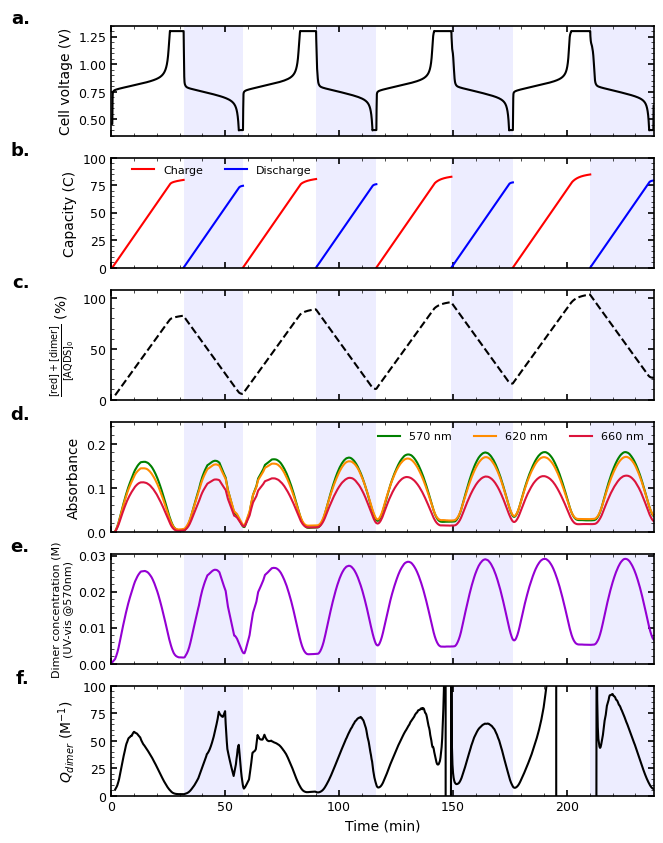

In [36]:
fig,ax = plt.subplots(nrows=6,ncols=1, sharex=True, figsize=(7,10))

# A) cell voltage
cell_time = df_cap['Run Time (h)']*60
# cell voltage profile
ax[0].plot(cell_time, df_cell['Potential (V)'], 'k')
ax[0].set_ylabel("Cell voltage (V)")
ax[0].set_ylim(0.35,1.35)
##############################################
# B) Capacity

ff = "2023-12-12_fullcell_aqds_vanadium_insituUVvis.csv"

c_list = [1,2,3,4] # cycles

x1, y1, *_ = selector.cycle_data_selector(c_list, cycle_data_path, ff, plot=False).cycle_plotter('discharge', 'time', 'discharge_capacity')
x2, y2, *_ = selector.cycle_data_selector(c_list, cycle_data_path, ff, plot=False).cycle_plotter('charge', 'time', 'charge_capacity')

for x,y in zip(x2,y2):
    # days to minutes
    ax[1].plot(x*24*60, y, 'r-')
for x,y in zip(x1,y1):
    # days to minutes
    ax[1].plot(x*24*60, y, 'b-')
#
ax[1].set_ylabel("Capacity (C)")
ax[1].set_ylim(0,100)
line1 = Line2D([], [], color='r', linestyle='-', label='Charge')
line2 = Line2D([], [], color='b', linestyle='-', label='Discharge')
ax[1].legend(handles=[line1,line2],frameon=False, ncols=2, loc=(0.03,0.8))
########################################
# C) SOC % [red] + [dimer] / [AQDS]_o
cap_x = x_3min[7:]
cap_y = y_3min[7:]*3600 # Ah to C
theory_cap = (96485.33 * 2 * 0.005 * 0.1) # 2 electrons, 5 mL CLS, 0.1 M
soc_y = cap_y / theory_cap
ax[2].plot(cap_x, soc_y*100, 'k--')
ax[2].set_ylim(bottom=0)

ax[2].set_ylabel(r"$\mathrm{\frac{[red]+[dimer]}{[AQDS]_{0}}~(\%)}$")
#################################################
# D) Absorbance from UV-vis, dimer absorbance
data_570 = np.array(abs_570_smooth)[new_sort]
data_620 = np.array(abs_620_smooth)[new_sort]
data_660 = np.array(abs_660_smooth)[new_sort]

abs_570_x, abs_570_y = running_avg(uv_time, data_570, 15)
abs_620_x, abs_620_y = running_avg(uv_time, data_620, 15)
abs_660_x, abs_660_y = running_avg(uv_time, data_660, 15)

# adjusted absorbance due to baseline
adjust_570_abs = [(i-abs_570_y[0]) for i in abs_570_y]
adjust_620_abs = [(i-abs_620_y[0]) for i in abs_620_y]
adjust_660_abs = [(i-abs_660_y[0]) for i in abs_660_y]

ax[3].plot(abs_570_x, adjust_570_abs, 'green', label="570 nm")
ax[3].plot(abs_620_x, adjust_620_abs, 'darkorange', label="620 nm")
ax[3].plot(abs_660_x, adjust_660_abs, 'crimson', label="660 nm")
ax[3].set_ylim(0,0.25)
ax[3].set_ylabel('Absorbance')
ax[3].legend(frameon=False, ncols=3)
########################################################
# E) Dimer concentration from UV-vis at 570 nm
dimer_conc_570 = conc_from_abs(data_570, 649.78) # 571.4 nm
dimer_conc_620 = conc_from_abs(data_620, 615.94) # 620.2 nm
dimer_conc_660 = conc_from_abs(data_660, 486.03) # 660.9 nm

# adjusted conc due to baseline
adjust_570_conc = [(i-dimer_conc_570[0]) for i in dimer_conc_570]
adjust_620_conc = [(i-dimer_conc_620[0]) for i in dimer_conc_620]
adjust_660_conc = [(i-dimer_conc_660[0]) for i in dimer_conc_660]

avg_dimer_conc_x, avg_dimer_conc_y = running_avg(uv_time, adjust_570_conc, 15)
x_plot_dimer_conc = np.insert(avg_dimer_conc_x, 0, 0.0)
y_plot_dimer_conc = np.insert(avg_dimer_conc_y, 0, 0.0)
ax[4].plot(x_plot_dimer_conc, y_plot_dimer_conc, color='darkviolet')
ax[4].set_ylim(bottom=0)
ax[4].set_ylabel("Dimer concentration (M)\n(UV-vis @570nm)", fontsize=8)
##################################################
# F) 
a = avg_dimer_conc_y[1:970] 
q_dim_conc = np.where(a > 0, a, 0)

Q_dimer = k_dimer_calc(q_dim_conc, soc_y[1:], 0.1)

ax[5].plot(abs_570_x[:969], Q_dimer, 'k')
ax[5].set_ylim(0,100)
ax[5].set_xlim(0, 238)
ax[5].set_xlabel('Time (min)')
ax[5].set_ylabel(r'$Q_{dimer}~\mathrm{(M^{-1})}$ ')

# shading for discharge
region_y = np.linspace(-10,150) 

# time for discharge cycles
disch_delims = [31.81, 57.86, 89.92, 116.36, 149.29, 176.26, 210.20, 237.89]
for i in range(4):
    for a in fig.axes: 
        a.fill_betweenx(y=region_y, x1=disch_delims[2*i], x2=disch_delims[(2*i) + 1], facecolor='blue', alpha=0.07, zorder=0)
#
ax[0].text(-0.15, 1.15, 'a.', transform=ax[0].transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax[1].text(-0.15, 1.15, 'b.', transform=ax[1].transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax[2].text(-0.15, 1.15, 'c.', transform=ax[2].transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax[3].text(-0.15, 1.15, 'd.', transform=ax[3].transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax[4].text(-0.15, 1.15, 'e.', transform=ax[4].transAxes, fontsize=13, fontweight='bold', va='top', ha='right')
ax[5].text(-0.15, 1.15, 'f.', transform=ax[5].transAxes, fontsize=13, fontweight='bold', va='top', ha='right')

# Figure S11

90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
K_dimer: 50, k_f: 0.025, fade rate: 0.058%/day, 1st discharge: 76.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
K_dimer: 50, k_f: 0.03, fade rate: 0.057%/day, 1st discharge: 79.8 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
K_dimer: 50, k_f: 0.035, fade rate: 0.057%/day, 1st discharge: 82.2 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
K_dimer: 75, k_f: 0.025, fade rate: 0.060%/day, 1st discharge: 66.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time duration reached.
K_dimer: 75, k_f: 0.03, fade rate: 0.060%/day, 1st discharge: 71.5 C
90000 sec of cycling, time steps: 0.05 sec
Simulation stopped after 1800000 time steps: time dura

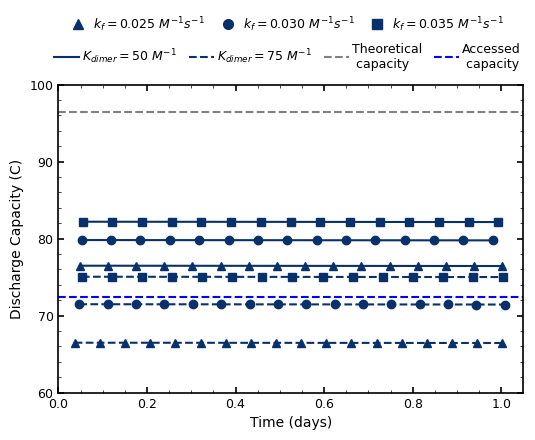

In [49]:
chem_deg = ChemicalDegradationReduced(rate_order=1, rate_constant=1.0e-8)
cross = Crossover(membrane_thickness=183, permeability_ox=2.3e-10, permeability_red=2.3e-10)

k_dimer = [50, 75]
k_for = [0.025, 0.030, 0.035]

all_data_cap = []
all_data_time = []
all_labels = []
# timing
start_t = time()

for d in k_dimer:
    for f in k_for:
        k_b = f / d
        dimer_cls = Dimerization(forward_rate_constant=f, backward_rate_constant=k_b)
        dimer_ncls = Dimerization(forward_rate_constant=f, backward_rate_constant=k_b)

        multi_cls = MultiDegradationMechanism([chem_deg, dimer_cls])
        multi_ncls = MultiDegradationMechanism([chem_deg, dimer_ncls])

        cell = ZeroDModel(volume_cls=0.005,      # L
                          volume_ncls=0.010,     # L
                          c_ox_cls=0.05,         # M
                          c_red_cls=0.05,        # M
                          c_ox_ncls=0.05,        # M
                          c_red_ncls=0.05,       # M
                          ocv_50_soc=0.0,        # V
                          resistance=0.088,      # ohms
                          k_0_cls=1e-3,          # cm/s
                          k_0_ncls=1e-3,         # cm/s
                          time_step=0.05,        # sec
                          num_electrons_cls=2,   # electrons
                          num_electrons_ncls=2,  # electrons
                          )

        protocol = ConstantCurrentConstantVoltage(voltage_limit_charge=0.2,
                                                  voltage_limit_discharge=-0.2,
                                                  current_cutoff_charge=0.005,
                                                  current_cutoff_discharge=-0.005,
                                                  current=0.05)
        # putting it all together
        all_results = protocol.run(cell_model=cell,
                                   duration=90000,  # cycle time to simulate (s)
                                   cls_degradation=multi_cls,
                                   ncls_degradation=multi_ncls,
                                   crossover=cross,
                                   )
        d_time = [t/86400 for t in all_results.discharge_cycle_time]  # now time is in days
        disch = all_results.discharge_cycle_capacity
        all_data_cap.append(disch)
        all_data_time.append(d_time)
        norm_cap_discharge = [(i / disch[0]) * 100 for i in disch]

        slope, *_ = data_fitting(d_time[1:], np.log(disch[1:]))
        print(f"K_dimer: {d}, k_f: {f}, fade rate: {slope*-100:.3f}%/day, 1st discharge: {disch[0]:.1f} C")
        lab = f"K_dimer: {d}, k_f: {f}"
        all_labels.append(lab)
#
end_t = time()
total_min = (end_t - start_t) / 60
print(f"elapsed time: {total_min:.1f} min")

# plotting

fig,ax = plt.subplots(figsize=(6,4))

cc = c_map = plt.cm.Blues([1.0])

mm = ['^', 'o', 's','^', 'o', 's',]
l_sty = ['-','-','-','--','--','--']

for idx,(x,y) in enumerate(zip(all_data_time, all_data_cap)):
    ax.plot(x, y, marker=mm[idx], color=cc, linestyle=l_sty[idx])
#
ax.axhline(96.48, color='gray', linestyle='--')

ax.axhline(72.4, color='b', linestyle='--')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Discharge Capacity (C)')
ax.set_yticks([60, 70, 80, 90, 100])
ax.set_xlim(0,1.05)

marksize=7
line1 = Line2D([], [], color=cc, marker='^', linestyle='none',markersize=marksize, label=r"$k_{f}=0.025~M^{-1}s^{-1}$")
line2 = Line2D([], [], color=cc, marker='o', linestyle='none',markersize=marksize, label=r"$k_{f}=0.030~M^{-1}s^{-1}$")
line3 = Line2D([], [], color=cc, marker='s', linestyle='none',markersize=marksize, label=r"$k_{f}=0.035~M^{-1}s^{-1}$")

line_a = Line2D([], [], color=cc, linestyle='-', label=r"$K_{dimer}=50~M^{-1}$")
line_b = Line2D([], [], color=cc, linestyle='--', label=r"$K_{dimer}=75~M^{-1}$")

line_c = Line2D([], [], color='gray', linestyle='--', label='Theoretical\n capacity')
line_d = Line2D([], [], color='blue', linestyle='--', label='Accessed\n capacity')

leg1 = plt.legend(handles=[line1,line2,line3], frameon=False, ncols=3,
          handletextpad=0.2, columnspacing=0.8, fontsize=9, loc=(0.005,1.15))

leg2 = plt.legend(handles=[line_a, line_b, line_c, line_d], frameon=False, ncols=4,
          handletextpad=0.2, columnspacing=1, fontsize=9,loc=(-0.02,1.03))

fig.add_artist(leg1)